In [1]:
%matplotlib inline
from brian2 import *

## Brian's unit system

All the standard SI units are available using their name (volt, siemens, meter (or metre), second, etc.), together with standard prefixes n (nano), u (micro), m (milli), k (kilo), M (mega), etc.

Because it would lead to clashes with user-defined variable names too often, single letter names are *not* defined (e.g. no `s` or `m`), but for convenience the most commonly used abbreviations for neuroscience are available (e.g. `ms` instead of `msecond`, `mV` instead of `mvolt`, `nS` instead of `nsiemens`, etc.)

Brian complains when using physical quantities incorrectly

In [2]:
s = 3*mmetre/second
s


0.003 * metre * second ** -1

Membrane potential equation:
$$
\tau\frac{d V_m}{dt} = E_L - V_m + R I_{inj}
$$

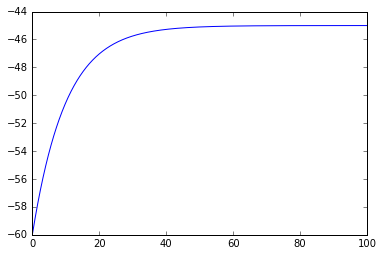

In [3]:
start_scope()

# Constants are standard Python variables

tau = 10*ms   # time constant
R = 50*Mohm   # membrane resistance
E_L = -70*mV  # leak reversal potential
I_inj = 0.5*nA  # injected current

# Equations follow mathematical notation and are stored in Python strings
# Notes:
#   * the left-hand side has to be only dX/dt, e.g. the time constant from
#     the equation above has to be on the right-hand side.
#   * the unit after the ":" is the unit of the variable, not the unit of
#     two sides of the equations (which would be "volt/second")
eqs = '''
dV_m/dt = (E_L - V_m + R*I_inj)/tau : volt
'''

neuron = NeuronGroup(1, eqs)
# Setting the initial condition
neuron.V_m = -60*mV

# record=True means "record all neurons". Since we only have one neuron,
# using record=0 would have done the same thing
mon = StateMonitor(neuron, 'V_m', record=True)

run(100*ms)
# Dividing by a unit of the right scale gives nicer plots
plot(mon.t/ms, mon.V_m[0]/mV)

### [Exercise: time dependent current]

Replace the injected current in the model above by a current that changes in time.

*Hints:*

* Equations can refer to all defined constants and variables, as well as to a few standard variables/constants that are predefined, e.g.:

`N` (number of neurons in the group), `i` (index of the neuron), `t` (current time), `dt` (the time step used for the simulation)
* Equations can make use of standard mathematical functions, e.g. `exp`, `sin`, `sqrt`, ...
* Equations can be made more readable by introducing "subexpressions", i.e. short names for longer terms. For example, the following two definitions do the same thing:


```Python
eqs = '''
dV_m/dt = (E_L - V_m + R*I_inj)/tau : volt
'''
eqs = '''
dV_m/dt = (E_L - V_m + V_inj)/tau : volt
V_inj = R*I_inj : volt
'''
```

## Spiking neurons

Integrate-and-fire neuron models (like the model we are using here), only model the "passive" neuron, i.e. only its subthreshold state and not the generation of action potentials. Action potentials are counted whenever the membrane potential crosses a threshold and then the membrane potential is reset to a lower value.

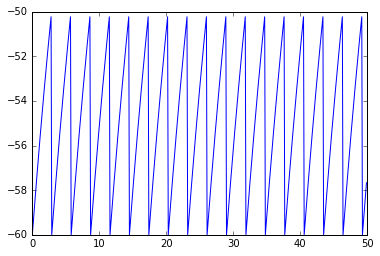

In [4]:
# First spiking neuron (no refractoriness)
start_scope()

tau = 10*ms   # time constant
R = 50*Mohm   # membrane resistance
E_L = -70*mV  # leak reversal potential
I_inj = 1*nA  # injected current

eqs = '''
dV_m/dt = (E_L - V_m + R*I_inj)/tau : volt
'''

neuron = NeuronGroup(1, eqs, threshold='V_m>-50*mV',
                     reset='V_m=-60*mV')
neuron.V_m = -60*mV

mon = StateMonitor(neuron, 'V_m', record=0)
run(50*ms)
plot(mon.t/ms, mon.V_m[0]/mV)

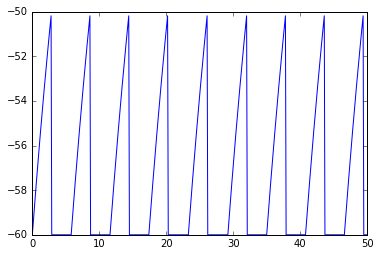

In [5]:
# First spiking neuron (no refractoriness)
start_scope()

tau = 10*ms   # time constant
R = 50*Mohm   # membrane resistance
E_L = -70*mV  # leak reversal potential
I_inj = 1*nA  # injected current

eqs = '''
# "unless refractory" means that the differential equation is
# only used when the neuron is not in its refractory period.
# During the refractory period, the variable remains "clamped"
# at its current value
dV_m/dt = (E_L - V_m + R*I_inj)/tau : volt (unless refractory)
'''

neuron = NeuronGroup(1, eqs, threshold='V_m>-50*mV',
                     reset='V_m=-60*mV',
                     refractory=3*ms)
neuron.V_m = -60*mV

mon = StateMonitor(neuron, 'V_m', record=0)
run(50*ms)
plot(mon.t/ms, mon.V_m[0]/mV)

### [Exercise: refractoriness, adaptive threshold]

1. What happens in the above model if you remove the `(unless refractory)` from the model? Explain what happens.
2. Implement an *adaptive threshold*. The new behaviour of the neuron should be like this (with $V_{th0}$ equal to the previous fixed threshold, i.e. $V_{th0} = -50\mathrm{mV}$, and $\tau_{th}=30\mathrm{ms}$):

$$
\tau\frac{d V_m}{dt} = E_L - V_m + R I_{inj}\\
\tau_{th}\frac{d V_{th}}{dt} = V_{th0} - V_{th}
$$
If $V_m > V_{th}$:
$$
V_m \leftarrow -60\mathrm{mV}\\
V_{th} \leftarrow V_{th} + 5\mathrm{mV}
$$


*Hint*: Note that the reset statement can in fact consist of multiple statements -- either use a Python multiline string, or separate statements with a semicolon.

## Noise

Equations can use a special variable `xi` that models a noise term $\xi$ (random function of time) -- this turns the equations into stochastic differential equations. Getting the physical units right when using noise can be tricky (it has units of $\frac{1}{\sqrt{second}}$) -- the usual thing to do is to include it like this:

$$
dx/dt = \dots + \sigma \frac{\xi}{\sqrt{\tau}}
$$

(where $\tau$ is a time constant in seconds and $\sigma$ has the same unit as $x$).

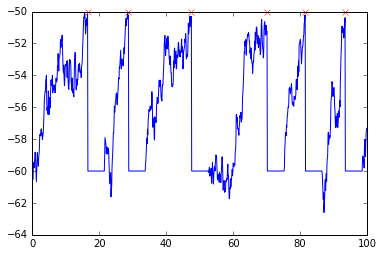

In [6]:
# Effect of noise on a neuron
start_scope()

tau = 10*ms   # time constant
R = 50*Mohm   # membrane resistance
E_L = -70*mV  # leak reversal potential
I_inj = .5*nA  # injected current
sigma = 5*mV

eqs = '''
dV_m/dt = (E_L - V_m + R*I_inj)/tau + sigma*xi/sqrt(tau): volt (unless refractory)
'''

neuron = NeuronGroup(1, eqs, threshold='V_m>-50*mV', reset='V_m=-60*mV',
                    refractory=5*ms)
neuron.V_m = -60*mV

mon = StateMonitor(neuron, 'V_m', record=True)
spike_mon = SpikeMonitor(neuron)

run(100*ms)

plot(mon.t/ms, mon.V_m[0]/mV)
plot(spike_mon.t/ms, ones(spike_mon.count[0])*-50, 'rx', clip_on=False)


WARNING  brian2.groups.group.Group.resolve.resolution_conflict: Variable I_inj is present in the namespace but is also an internal variable of neurongroup_2, the internal variable will be used.


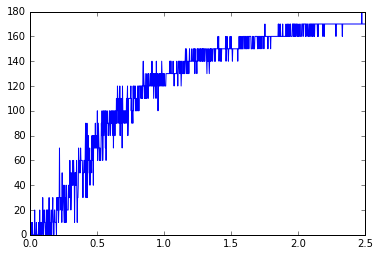

In [8]:
# f/I curve with noise
start_scope()

tau = 10*ms   # time constant
R = 50*Mohm   # membrane resistance
E_L = -70*mV  # leak reversal potential
sigma = 10*mV

eqs = '''
dV_m/dt = (E_L - V_m + R*I_inj)/tau + sigma*xi/sqrt(tau): volt (unless refractory)
# I_inj is no longer a constant but a different value for each neuron
I_inj : amp
'''

neuron = NeuronGroup(1000, eqs, threshold='V_m>-50*mV', reset='V_m=-60*mV',
                     refractory=5*ms)
neuron.V_m = -60*mV
# Each neuron has a different I_inj value, ranging from 0 to 2.5nA
neuron.I_inj = linspace(0, 1, len(neuron))*2.5*nA

spike_mon = SpikeMonitor(neuron)

run(100*ms)

# We plot the spike count for each neuron over the current input for that neuron, giving
# a classical f/I curve
# For low noise, this curve has a hard threshold, with higher noise it gets smoothed out
# (even very weak input sometimes leads to spike, due to the strong noise)
plot(neuron.I_inj/nA, spike_mon.count/(100*ms))
